In [1]:
from tools import *
import numpy as np

In [2]:
PATH_TO_LVK_DATA = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_analysis/GWTC_LVK_data/'
PATH_TO_RESULTS = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_analysis/'

In [3]:
waveform = 'IMRPhenomXPHM'

In [4]:
estimator = 'median'
events = np.loadtxt(PATH_TO_RESULTS + 'info/' + 'events_with_priors_%s.txt' %waveform, dtype=str)
with open(PATH_TO_RESULTS + 'info/' + 'detectors_dictionary.pkl', 'rb') as f:
    detectors = pickle.load(f)

# Store samples and confidence interval (90CL)

In [5]:
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']

## LVK

In [6]:
for event in events:
    samples_lvk = get_lvk_samples(PATH_TO_LVK_DATA, event, params, waveform)
    samples_lvk_df = pd.DataFrame(samples_lvk)
    samples_lvk_df.to_hdf(PATH_TO_RESULTS + 'results/samples/lvk_samples_%s.hdf5' %event, mode='w', key='root')

In [15]:
confidence_level = 90 # number between 0 and 100
conf_interval_lvk = {}
samples_len = {}
for event in events:
    samples = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/lvk_samples_%s.hdf5' %(event))
    samples_len[event] = len(samples)
    conf_interval_lvk[event] = get_confidence_interval(samples, params, confidence_level)


In [ ]:
conf_interval_lvk = pd.DataFrame(conf_interval_lvk)
conf_interval_lvk.to_hdf(PATH_TO_RESULTS + 'results/confidence_levels/conf_interval90_lvk_%s.hdf5' %estimator, mode='w', key='root')

In [18]:
with open(PATH_TO_RESULTS + 'info/' + 'samples_len_%s_%s.pkl' %(estimator, waveform), 'wb') as f:
        pickle.dump(samples_len, f)

## GWFish

In [6]:
with open(PATH_TO_RESULTS + 'info/' + 'samples_len_%s_%s.pkl' %(estimator, waveform), 'rb') as f:
    samples_len = pickle.load(f)

In [7]:
lbs_errs = ['snr', 'chirp_mass', 'mass_ratio', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn',
        'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'redshift', 
        'mass1_lvk', 'mass2_lvk', 'err_chirp_mass', 'err_mass_ratio', 'err_luminosity_distance', 'err_dec', 'err_ra',
        'err_theta_jn', 'err_psi', 'err_phase', 'err_geocent_time', 'err_a_1', 'err_a_2', 'err_tilt_1',
        'err_tilt_2', 'err_phi_12', 'err_phi_jl', 'err_sky_location']

In [8]:
time_data = {}
for event in events:
    label_err = get_label(detectors, event, estimator, 'errors')
    data = pd.read_csv(PATH_TO_RESULTS + 'results/gwfish_mChirp_q/' + label_err, names = lbs_errs, delimiter=' ', skiprows=1)
    time_data[event] = data['geocent_time'].iloc[0]

In [9]:
with open(PATH_TO_RESULTS + 'info/' + 'time_data_4priors_%s_%s.pkl' %(estimator, waveform), 'wb') as f:
        pickle.dump(time_data, f)

In [10]:
with open(PATH_TO_RESULTS + 'info/' + 'time_data_4priors_%s_%s.pkl' %(estimator, waveform), 'rb') as f:
    time_data = pickle.load(f)

In [11]:
np.random.seed(42)
for event in events:
    label_err = get_label(detectors, event, estimator, 'errors')
    label_cov = get_label(detectors, event, estimator, 'inv_fishers')
    data = pd.read_csv(PATH_TO_RESULTS + 'results/gwfish_m1_m2/' + label_err, names = lbs_errs, delimiter=' ', skiprows=1)
    mns = data[params].iloc[0].to_numpy()
    cov = np.load(PATH_TO_RESULTS + 'results/gwfish_m1_m2/' + label_cov)[0, :, :]
    samples = np.random.multivariate_normal(mns, cov, samples_len[event])
    samples_df = pd.DataFrame(samples, columns=params)
    samples_df.to_hdf(PATH_TO_RESULTS + 'results/samples/fisher_samples_%s_%s_m1_m2.hdf5' %(estimator, event), mode='w', key='root')

In [12]:
with open(PATH_TO_RESULTS + 'info/' + 'chirp_mass_priors_%s.pkl' %waveform, 'rb') as f:
    chirp_mass_priors = pickle.load(f)

In [13]:
# Build priors dictionary
my_priors = {}
for event in events:
    event_dict = {
        'chirp_mass': np.array([float(chirp_mass_priors[event][0]), float(chirp_mass_priors[event][1])]),
        'mass_ratio': np.array([0.05, 1.0]),
        'luminosity_distance': np.array([10, 10000]),
        'dec': np.array([-np.pi/2, np.pi/2]),
        'ra': np.array([0, 2*np.pi]),
        'theta_jn': np.array([0, np.pi]),
        'psi': np.array([0, np.pi]),
        'phase': np.array([0, 2*np.pi]),
        'geocent_time': np.array([time_data[event] - 0.1, time_data[event] + 0.1]),
        'a_1': np.array([0, 0.99]),
        'a_2': np.array([0, 0.99]),
        'tilt_1': np.array([0, np.pi]),
        'tilt_2': np.array([0, np.pi]),
        'phi_12': np.array([0, 2*np.pi]),
        'phi_jl': np.array([0, 2*np.pi])
    }
    my_priors[event] = event_dict
        

In [14]:
min_array = np.array([-np.inf, 0, 0, -np.pi/2, 0, 0, 0, 0, -np.inf, 0, 0, 0, 0, 0, 0])
max_array = np.array([np.inf, 1, 20000, np.pi/2, 2*np.pi, np.pi, np.pi, 2*np.pi, np.inf, 1, 1, np.pi, np.pi, 2*np.pi, 2*np.pi])

for event in events:
    label_err = get_label(detectors, event, estimator, 'errors')
    label_cov = get_label(detectors, event, estimator, 'inv_fishers')
    data = pd.read_csv(PATH_TO_RESULTS + 'results/gwfish_mChirp_q/' + label_err, names = lbs_errs, delimiter=' ', skiprows=1)
    mns = data[params].iloc[0].to_numpy()
    cov = np.load(PATH_TO_RESULTS + 'results/gwfish_mChirp_q/' + label_cov)[0, :, :]
    samples_tmvn = get_samples_from_TMVN(min_array, max_array, mns, cov, samples_len[event])
    new_df = pd.DataFrame(samples_tmvn.T, columns = params)
    posteriors = get_posteriors(new_df, my_priors[event], samples_len[event])
    posteriors_df = pd.DataFrame(posteriors, columns = params)
    posteriors_df.to_hdf(PATH_TO_RESULTS + 'results/samples/fisher_plus_priors_samples_%s_%s.hdf5' %(estimator, event), mode='w', key='root')

In [ ]:
conf_interval_fisher = {}
conf_interval_fisher_plus_priors = {}
confidence_level = 90
for event in events:
    samples = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/fisher_samples_%s_%s_m1_m2.hdf5' %(estimator, event))
    samples_plus_priors = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/fisher_plus_priors_samples_%s_%s.hdf5' %(estimator, event))
    conf_interval_fisher[event] = get_confidence_interval(samples, params, confidence_level)
    conf_interval_fisher_plus_priors[event] = get_confidence_interval(samples_plus_priors, params, confidence_level)

conf_interval_fisher = pd.DataFrame(conf_interval_fisher)
conf_interval_fisher_plus_priors = pd.DataFrame(conf_interval_fisher_plus_priors)
conf_interval_fisher.to_hdf(PATH_TO_RESULTS + 'results/confidence_levels/conf_interval90_fisher_%s.hdf5' %estimator, mode='w', key='root')
conf_interval_fisher_plus_priors.to_hdf(PATH_TO_RESULTS + 'results/confidence_levels/conf_interval90_fisher_plus_priors_%s.hdf5' %estimator, mode='w', key='root')

# Some Tests

In [15]:
posterior_lvk = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/lvk_samples_%s.hdf5' %events[0])
posterior_gwfish = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/fisher_samples_%s_%s.hdf5' %(estimator, events[0]))
posterior_gwfish_plus_priors = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/fisher_plus_priors_samples_%s_%s.hdf5' %(estimator, events[0]))

In [ ]:
posterior_gwfish_m1m2 = pd.read_hdf(PATH_TO_RESULTS + 'results/samples/fisher_samples_%s_%s_m1_m2.hdf5' %(estimator, events[0]))

In [16]:
import matplotlib.pyplot as plt

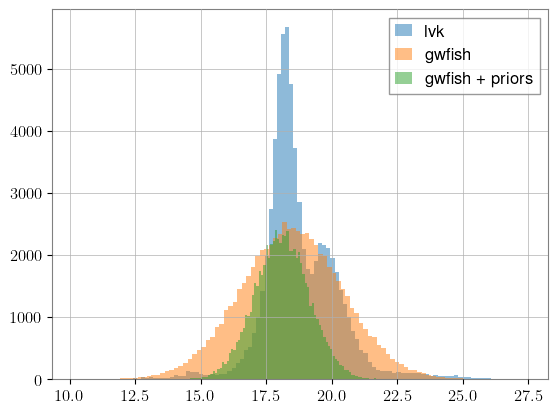

In [18]:
select_param = 'chirp_mass'
plt.hist(posterior_lvk[select_param], bins=100, alpha=0.5, label='lvk')
plt.hist(posterior_gwfish[select_param], bins=100, alpha=0.5, label='gwfish')
plt.hist(posterior_gwfish_plus_priors[select_param], bins=100, alpha=0.5, label='gwfish + priors')
plt.legend()
plt.show()

In [48]:
m_chirp_from_m1_m2, q_from_m1_m2 = from_m1_m2_to_mChirp_q(posterior_gwfish_m1m2['mass_1'], posterior_gwfish_m1m2['mass_2']) 

[]

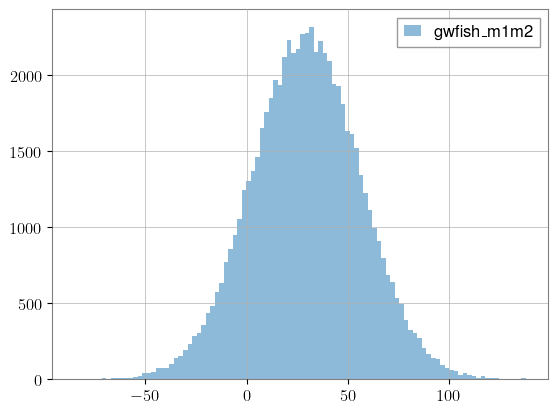

In [47]:
plt.hist(posterior_gwfish_m1m2['mass_1'], bins=100, alpha=0.5, label='gwfish_m1m2')
plt.legend()
plt.plot()

In [50]:
m1, m2 = from_mChirp_q_to_m1_m2(posterior_gwfish['chirp_mass'], posterior_gwfish['mass_ratio'])

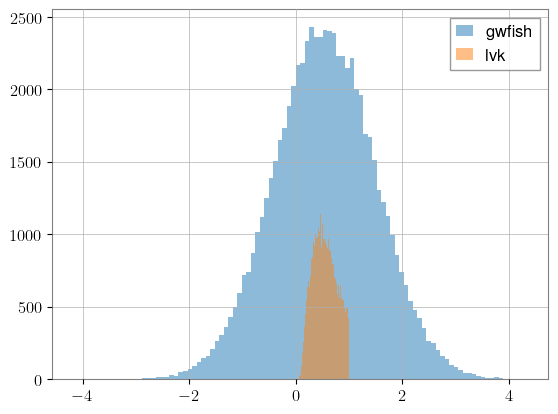

In [54]:
plt.hist(posterior_gwfish['mass_ratio'], bins=100, alpha=0.5, label='gwfish')
plt.hist(posterior_lvk['mass_ratio'], bins=100, alpha=0.5, label='lvk')
plt.legend()
plt.show()

In [55]:
events[0]

'IGWN-GWTC2p1-v2-GW151012_095443_PEDataRelease_mixed_cosmo'

[]

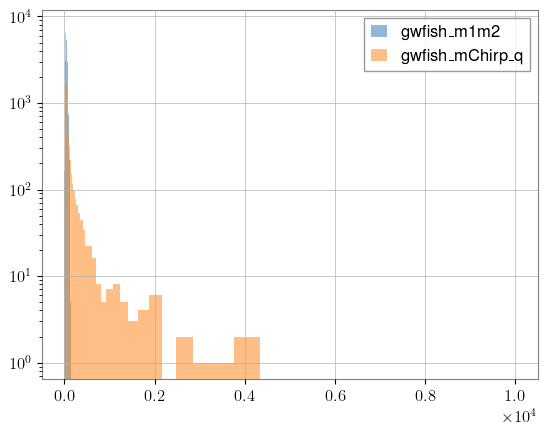

In [52]:
plt.hist(posterior_gwfish_m1m2['mass_1'], bins=np.logspace(-2,4,100), alpha=0.5, label='gwfish_m1m2')
plt.hist(m1, bins=np.logspace(-2,4,100), alpha=0.5, label='gwfish_mChirp_q')
plt.legend()
plt.yscale('log')
plt.plot()

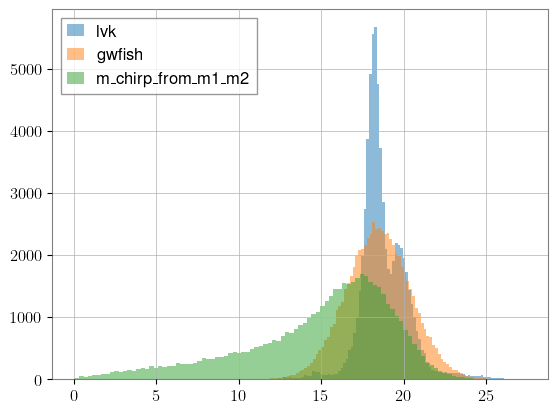

In [49]:
plt.hist(posterior_lvk['chirp_mass'], bins=100, alpha=0.5, label='lvk')
plt.hist(posterior_gwfish['chirp_mass'], bins=100, alpha=0.5, label='gwfish')
plt.hist(m_chirp_from_m1_m2, bins=100, alpha=0.5, label='m_chirp_from_m1_m2')
plt.legend()
plt.show()